In [2]:
import pandas as pd 
import os
import numpy as np
from skimage.io import imread
from sklearn.metrics import accuracy_score, classification_report
from sklearn.semi_supervised import SelfTrainingClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import random

In [3]:
def prepareDataNN(df):
    data = []
    labels = []
    df_filtered = pd.DataFrame(columns=["patch_filename", "plastic"])
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            data.append(im)
            labels.append(np.array(df.loc[i, 'plastic']))
            df_filtered = df_filtered.append(pd.Series(data={"patch_filename":df.loc[i, 'patch_filename'], "plastic":df.loc[i, 'plastic']}), ignore_index=True)
    return data, labels, df_filtered

In [4]:
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
df = df[df.plastic!=-1]
_,_,df = prepareDataNN(df) # filter patches of size < 256 * 256

df_plastic = df[df.plastic==1].reset_index()
df_noplastic = df[df.plastic==0].reset_index()
len(df_plastic), len(df_noplastic)

(583, 575)

In [10]:
partition = .85
test_set = df.copy()
print(len(test_set))
training_set = test_set.sample(frac=partition)
test_set = pd.merge(test_set, training_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge'], axis=1).reset_index()
print(len(test_set))
validation_set = test_set.sample(frac=.5)
test_set = pd.merge(test_set, validation_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge','index'], axis=1).reset_index()
print(len(test_set))


1158
174
87


In [11]:
print(len(training_set[training_set['plastic']==0]), len(training_set[training_set['plastic']==1]) )
print(len(validation_set[validation_set['plastic']==0]), len(validation_set[validation_set['plastic']==1]) )
print(len(test_set[test_set['plastic']==0]), len(test_set[test_set['plastic']==1]) )

478 506
53 34
44 43


In [12]:
def get_preditictions(model, test_data):
    pred_prob = model.predict(np.array(test_data))
    pred_class = []
    for p in pred_prob:
        if p >= .5:
            pred_class.append(1)
        else:
            pred_class.append(0)
    print(classification_report(test_labels, pred_class))
    return (pred_prob, pred_class)

In [13]:
training_data, training_labels, _ = prepareDataNN(training_set.reset_index())
validation_data, validation_labels, _ = prepareDataNN(validation_set.reset_index())
test_data, test_labels, _ = prepareDataNN(test_set)

In [7]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      #layers.RandomTranslation(0.8, 0.5),
      #layers.RandomZoom(0.5),
      layers.RandomContrast(0.1),
    ]
)

2022-03-17 15:22:19.323906: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-17 15:22:19.324032: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (giorgia-PX60-6QE): /proc/driver/nvidia/version does not exist
2022-03-17 15:22:19.347679: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# preprocess data 
inputs = keras.Input(shape = (256, 256, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)

# load pre-trained model and weights without last layer
x = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))(x)

# add layers on top
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# final model to train
tf_model_mobnet = keras.Model(inputs, outputs)

for layer in tf_model_mobnet.layers:
    if layer.name == 'mobilenetv2_1.00_224':
        print(len(layer.layers))
        for l in layer.layers[-20:]:
            l.trainable = True

154


In [24]:
epochs = 20
callbacks = [
    keras.callbacks.ModelCheckpoint("ckpts/mobnetv2_{epoch}.h5", save_best_only=True),
]
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

tf_model_mobnet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
hist_mobnet = tf_model_mobnet.fit(
    x=np.array(training_data), y=np.array(training_labels) , epochs=epochs, callbacks=[callbacks, tensorboard], shuffle=True, batch_size=16, validation_data=(np.array(validation_data), np.array(validation_labels))
)

# save history 
with open('ckpts/trainHistoryMobNetV2', 'wb') as file_pi:
    pickle.dump(hist_mobnet.history, file_pi)

Epoch 1/20
62/62 [==============================] - 100s 2s/step - loss: 0.5576 - accuracy: 0.7683 - val_loss: 6.7120 - val_accuracy: 0.4943
Epoch 2/20
62/62 [==============================] - 93s 2s/step - loss: 0.4151 - accuracy: 0.8161 - val_loss: 1.4251 - val_accuracy: 0.5057
Epoch 3/20
62/62 [==============================] - 92s 1s/step - loss: 0.3641 - accuracy: 0.8455 - val_loss: 2.4415 - val_accuracy: 0.5517
Epoch 4/20
62/62 [==============================] - 92s 1s/step - loss: 0.4114 - accuracy: 0.8191 - val_loss: 1.8632 - val_accuracy: 0.5747
Epoch 5/20
62/62 [==============================] - 92s 1s/step - loss: 0.3760 - accuracy: 0.8354 - val_loss: 0.7228 - val_accuracy: 0.7586
Epoch 6/20
62/62 [==============================] - 92s 1s/step - loss: 0.3481 - accuracy: 0.8587 - val_loss: 0.9847 - val_accuracy: 0.7471
Epoch 7/20
62/62 [==============================] - 92s 1s/step - loss: 0.3343 - accuracy: 0.8628 - val_loss: 0.8535 - val_accuracy: 0.7356
Epoch 8/20
62/62 [=

In [16]:
pred_probs_mobnet, pred_class_mobnet = get_preditictions(tf_model_mobnet, test_data)

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        44
         1.0       0.79      0.79      0.79        43

    accuracy                           0.79        87
   macro avg       0.79      0.79      0.79        87
weighted avg       0.79      0.79      0.79        87



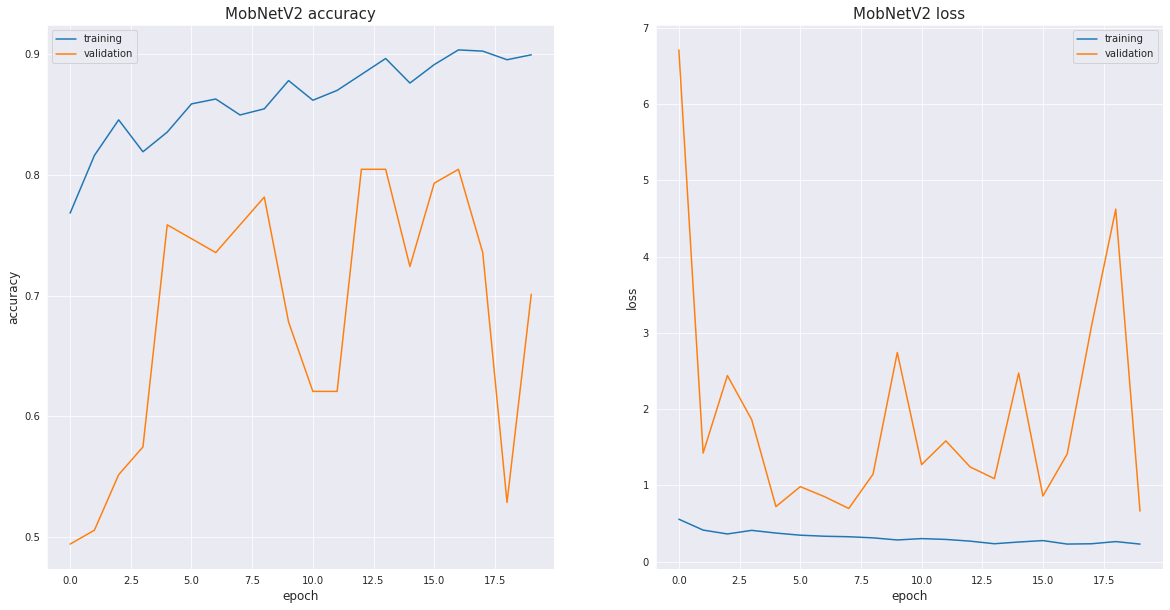

In [27]:
hist_mobnet = pd.read_pickle('ckpts/trainHistoryMobNetV2')

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.subplot(121)
plt.plot(hist_mobnet['accuracy'])
plt.plot(hist_mobnet['val_accuracy'])
plt.title('MobNetV2 accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper left')
plt.subplot(122)
plt.plot(hist_mobnet['loss'])
plt.plot(hist_mobnet['val_loss'])
plt.title('MobNetV2 loss', fontsize=15)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("/home/giorgia/Desktop/MAI/Thesis/figures/MobNetV2_training.png")

In [18]:
tf_model_mobnet.load_weights("ckpts/mobnetv2_20.h5")
tf_model_mobnet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
pred_probs_mobnet, pred_class_mobnet = get_preditictions(tf_model_mobnet, test_data)

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80        44
         1.0       0.79      0.79      0.79        43

    accuracy                           0.79        87
   macro avg       0.79      0.79      0.79        87
weighted avg       0.79      0.79      0.79        87



### Self-Supervised

In [31]:
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
len(df[df.plastic==-1])
df_unlabeled = df[df.plastic==-1]
X, Y, _ = prepareDataNN(df_unlabeled)

In [32]:
def label_data(model, unlabeled_data, th=.75):
    pred_prob = model.predict(np.array(unlabeled_data))
    pred_class = []
    for p in pred_prob:
        if p >= th:
            pred_class.append(1)
        else:
            pred_class.append(0)
    return (pred_prob, pred_class)

In [40]:
step = 1000
epochs = 5
callbacks = [
    keras.callbacks.ModelCheckpoint("ckpts/mobnetv2_ss_{epoch}.h5", save_best_only=True),
]
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                histogram_freq=1, 
                write_graph=True, 
                write_images=False)
tf_model_mobnet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
for i in range(0, len(X), step):
    if i + step > len(X):
        end = len(X)
    else:
        end = i + step
    _, Y_train = label_data(tf_model_mobnet, X[i:end])
    training_data += X[i:end]
    training_labels += Y_train
    hist = tf_model_mobnet.fit(
        x=np.array(training_data), y=np.array(training_labels) , epochs=epochs, callbacks=[callbacks, tensorboard], shuffle=True, batch_size=32, validation_data=(np.array(validation_data), np.array(validation_labels))
    )

Epoch 1/5


2022-03-17 17:04:24.583258: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 783286272 exceeds 10% of free system memory.


In [ ]:
pred_probs_mobnet, pred_class_mobnet = get_preditictions(tf_model_mobnet, test_data)